<a href="https://colab.research.google.com/github/SJY-coder/TSP-demo/blob/master/TSP_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

本プロジェクトの目標は当日の株式の情報と当日の人気ニュース（本プロジェクトでは使わなかったですが、目標としてTwitterのAPIを用いて人気tweetを使うことです。）をもとに一日後の株の変動価額を予想することです。


ここではKaggleからのDaily News for Stock Market Predictionのデータセットを使いました。

url-- https://www.kaggle.com/aaron7sun/stocknews

このプログラムを書いた当時には提出を想定せずにコメントを英語に書いた点、何とぞ理解いただきたく、ご承知ください。


ニュースなどでは自然後が使われているため、sentence_transformers（pretrained by RoBERTa）というパイソンライブラリーを用いて各文章を意味を持つベクトルとして表現しました。

一日には25個のニュースがありまして、ベクトル化した文章をRNNにインプットしｎ次の特性を出力できるようにしました。出力された特性はDNNに入れて出た株価の特性と合流され、また新しいDNNに入って次の日の株価を予想できることを目標としました。

**Fetch Kaggle Datasets into Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']="/content/gdrive/My Drive/Kaggle"

# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
#only for the first runtime
# !kaggle datasets download -d aaron7sun/stocknews

In [ ]:
!ls

Combined_News_DJIA.csv	RedditNews.csv	upload_DJIA_table.csv
kaggle.json		stocknews.zip


In [ ]:
#only for the first runtime
# !unzip \*.zip && rm *.zip

In [ ]:
!ls

Combined_News_DJIA.csv	kaggle.json  RedditNews.csv  upload_DJIA_table.csv
fin_model.png		model.h5     stocknews.zip


#**Preprocessing Datasets**

### merge 'Combined_News_DJIA.csv' with 'upload_DJIA_table.csv' to predict precise p-change(next day close price - next dat open price) for the next day.


In [ ]:
import pandas as pd
df1 = pd.read_csv('Combined_News_DJIA.csv')
df2 = pd.read_csv('upload_DJIA_table.csv')
#merge on 'Date' column for left&right
full_df = df1.merge(df2, left_on = 'Date', right_on = 'Date')

In [ ]:
print(df1.shape,"+",df2.shape,"=>",full_df.shape)
full_df.head()

(1989, 27) + (1989, 7) => (1989, 33)


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Volume,Adj Close
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS 

In [ ]:
import numpy as np
import string
pd.options.mode.chained_assignment = None
#giving df a new column of nexts day's open price & close price for target + text preprocessing
str_df = full_df.iloc[:,2:27].astype(str)
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
  """custom function to remove punctuation"""
  return text.translate(str.maketrans('', '',PUNCT_TO_REMOVE))
def remove_b(str_df): 
  for i in range(str_df.shape[1]):
    str_df.iloc[:,i] = str_df.iloc[:,i].apply(lambda text: remove_punctuation(text))
    for j in range(len(str_df.iloc[:,1])):
      #deleting 'b' in front of sentence
      str_df.iloc[:,i][j] = str_df.iloc[:,i][j][1:]
  return str_df
remove_b(str_df)
full_df.iloc[:,2:27] = str_df
full_df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Volume,Adj Close
0,2008-08-08,0,Georgia downs two Russian warplanes as countri...,BREAKING Musharraf to be impeached,Russia Today Columns of troops roll into South...,Russian tanks are moving towards the capital o...,Afghan children raped with impunity UN officia...,150 Russian tanks have entered South Ossetia w...,Breaking Georgia invades South Ossetia Russia ...,The enemy combatent trials are nothing but a s...,Georgian troops retreat from S Osettain capita...,Did the US Prep Georgia for War with Russia,Rice Gives Green Light for Israel to Attack Ir...,AnnouncingClass Action Lawsuit on Behalf of Am...,SoRussia and Georgia are at war and the NYTs t...,China tells Bush to stay out of other countrie...,Did World War III start today,Georgia Invades South Ossetia if Russia gets ...,AlQaeda Faces Islamist Backlash,Condoleezza Rice The US would not act to preve...,This is a busy day The European Union has app...,Georgia will withdraw 1000 soldiers from Iraq ...,Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis Georgia invades South Ossetia,Indian shoe manufactory And again in a serie...,Visitors Suffering from Mental Illnesses Banne...,No Help for Mexicos Kidnapping Surge,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1,2008-08-11,1,Why wont America and Nato help us If they wont...,Bush puts foot down on Georgian conflict,Jewish Georgian minister Thanks to Israeli tra...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks faked,What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in SOssetia blames ...,Welcome To World War IV Now In High Definition,Georgias move a mistake of monumental proporti...,Russia presses deeper into Georgia US says reg...,Abhinav Bindra wins first ever Individual Olym...,US ship heads for Arctic to define territory,Drivers in a Jerusalem taxi station threaten t...,The French Team is Stunned by Phelps and the 4...,Israel and the US behind the Georgian aggression,Do not believe TV neither Russian nor Georgian...,Riots are still going on in Montreal Canada be...,China to overtake US as largest manufacturer,War in South Ossetia PICS,Israeli Physicians Group Condemns State Torture,Russia has just beaten the United States over...,Perhaps the question about the Georgia Russia...,Russia is so much better at war,So this is what its come to trading sex for food,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
2,2008-08-12,0,Remember that adorable 9yearold who sang at th...,Russia ends Georgia operation,If we had no sexual harassment we would have n...,AlQaeda is losing support in Iraq because of a...,Ceasefire in Georgia Putin Outmaneuvers the West,Why Microsoft and Intel tried to kill the XO 1...,Stratfor The RussoGeorgian War and the Balance...,Im Trying to Get a Sense of This Whole Georgia...,The US military was surprised by the timing an...,US Beats War Drum as Iran Dumps the Dollar,Gorbachev Georgian military attacked the South...,CNN use footage of Tskhinvali ruins to cover G...,Beginning a war as the Olympics were opening v...,55 pyramids as large as the Luxor stacked into...,The 11 Top Party Cities in the World,US troops still in Georgia did you know they w...,Why Russias response to Georgia was right,Gorbachev accuses US of making a serious blund...,Russia Georgia and NATO Cold War Two,Remember that adorable 62yearold who led your ...,War in Georgia The Israeli connection,All signs point to the US encouraging Georgia ...,Christopher King argues that the US and NATO a...,America The New Mexico,BBC NEWS AsiaPacific Extinction by man not c...,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
3,2008-08-13,0,US refuses Israel weapons to attac

In [ ]:
#create new column with next row's open & close price as target and drop last row
df = full_df
df_open_tmp = pd.DataFrame(df.iloc[1:,-6])
df_close_tmp = pd.DataFrame(df.iloc[1:,-3])
new_row_1 = pd.DataFrame({"Open": [0]})
new_row_2 = pd.DataFrame({"Close": [0]})
new_row_open = df_open_tmp.append(new_row_1, ignore_index=True)
new_row_close = df_close_tmp.append(new_row_2, ignore_index=True)
df["p-Open"] = new_row_open
df["p-Close"] = new_row_close
df = df.iloc[:-1,:]

In [ ]:
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Open,High,Low,Close,Volume,Adj Close,p-Open,p-Close
0,2008-08-08,0,Georgia downs two Russian warplanes as countri...,BREAKING Musharraf to be impeached,Russia Today Columns of troops roll into South...,Russian tanks are moving towards the capital o...,Afghan children raped with impunity UN officia...,150 Russian tanks have entered South Ossetia w...,Breaking Georgia invades South Ossetia Russia ...,The enemy combatent trials are nothing but a s...,Georgian troops retreat from S Osettain capita...,Did the US Prep Georgia for War with Russia,Rice Gives Green Light for Israel to Attack Ir...,AnnouncingClass Action Lawsuit on Behalf of Am...,SoRussia and Georgia are at war and the NYTs t...,China tells Bush to stay out of other countrie...,Did World War III start today,Georgia Invades South Ossetia if Russia gets ...,AlQaeda Faces Islamist Backlash,Condoleezza Rice The US would not act to preve...,This is a busy day The European Union has app...,Georgia will withdraw 1000 soldiers from Iraq ...,Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis Georgia invades South Ossetia,Indian shoe manufactory And again in a serie...,Visitors Suffering from Mental Illnesses Banne...,No Help for Mexicos Kidnapping Surge,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,11729.669922,11782.349609
1,2008-08-11,1,Why wont America and Nato help us If they wont...,Bush puts foot down on Georgian conflict,Jewish Georgian minister Thanks to Israeli tra...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks faked,What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in SOssetia blames ...,Welcome To World War IV Now In High Definition,Georgias move a mistake of monumental proporti...,Russia presses deeper into Georgia US says reg...,Abhinav Bindra wins first ever Individual Olym...,US ship heads for Arctic to define territory,Drivers in a Jerusalem taxi station threaten t...,The French Team is Stunned by Phelps and the 4...,Israel and the US behind the Georgian aggression,Do not believe TV neither Russian nor Georgian...,Riots are still going on in Montreal Canada be...,China to overtake US as largest manufacturer,War in South Ossetia PICS,Israeli Physicians Group Condemns State Torture,Russia has just beaten the United States over...,Perhaps the question about the Georgia Russia...,Russia is so much better at war,So this is what its come to trading sex for food,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,11781.700195,11642.469727
2,2008-08-12,0,Remember that adorable 9yearold who sang at th...,Russia ends Georgia operation,If we had no sexual harassment we would have n...,AlQaeda is losing support in Iraq because of a...,Ceasefire in Georgia Putin Outmaneuvers the West,Why Microsoft and Intel tried to kill the XO 1...,Stratfor The RussoGeorgian War and the Balance...,Im Trying to Get a Sense of This Whole Georgia...,The US military was surprised by the timing an...,US Beats War Drum as Iran Dumps the Dollar,Gorbachev Georgian military attacked the South...,CNN use footage of Tskhinvali ruins to cover G...,Beginning a war as the Olympics were opening v...,55 pyramids as large as the Luxor stacked into...,The 11 Top Party Cities in the World,US troops still in Georgia did you know they w...,Why Russias response to Georgia was right,Gorbachev accuses US of making a serious blund...,Russia Georgia and NATO Cold War Two,Remember that adorable 62yearold who led your ...,War in Georgia The Israeli connection,All signs point to the US encouraging Georgia ...,Christopher King argues that the US and NATO a...,America The New Mexico,BBC NEWS AsiaPacific Extinction by man not c...,11781.700195,11782.349609,11601.519531,11642.469727,17359

In [ ]:
#spliting sentiment,stock price,target stock price for model
df_num, df_y, df_sen = df.iloc[:,-8:-2],df.iloc[:,-2:], df.iloc[:,2:-8]
# if you want label to predict uncomment this line of code. In this notebook I will not consider current days label to predict next day's change
# df_y.insert(0,'Label',df.iloc[:,1])

print(df_num.head(),df_num.shape,'\n',df_sen,df_sen.shape,'\n',df_y,df_y.shape)


           Open          High  ...     Volume     Adj Close
0  11432.089844  11759.959961  ...  212830000  11734.320312
1  11729.669922  11867.110352  ...  183190000  11782.349609
2  11781.700195  11782.349609  ...  173590000  11642.469727
3  11632.809570  11633.780273  ...  182550000  11532.959961
4  11532.070312  11718.280273  ...  159790000  11615.929688

[5 rows x 6 columns] (1988, 6) 
                                                    Top1  ...                                              Top25
0     Georgia downs two Russian warplanes as countri...  ...               No Help for Mexicos Kidnapping Surge
1     Why wont America and Nato help us If they wont...  ...   So this is what its come to trading sex for food
2     Remember that adorable 9yearold who sang at th...  ...  BBC NEWS  AsiaPacific  Extinction by man not c...
3       US refuses Israel weapons to attack Iran report  ...  2006 Nobel laureate Aleksander Solzhenitsyn ac...
4     All the experts admit that we should leg

In [ ]:
 df_y['p-change'] = df_y['p-Close']-df_y['p-Open']

In [ ]:
pd.DataFrame(df_y)
del df_y['p-Close']
del df_y['p-Open']
df_y.head()

,p-change
0,52.679687
1,-139.230468
2,-99.849609
3,83.859376
4,48.690430


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


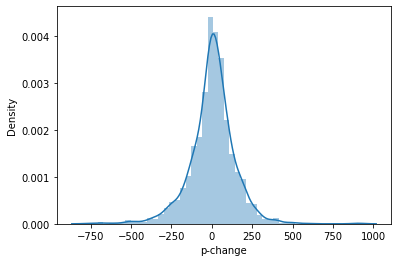

In [ ]:
#get an insight of df_y and classify df_y for better accuracy
import seaborn as sns
sns.distplot(df_y['p-change'])

In [ ]:
def label_surplus(row):
  if row['p-change']>0:
    return 0.9 #label-smoothing
  else:
    return 0.1 #label-smoothing
df_y['plus_or_minus'] = df_y.apply (lambda row: label_surplus(row), axis=1)
up_down = np.delete(np.array(df_y),0,1)
print(up_down,up_down_pred.shape)

[[0.9]
 [0.1]
 [0.1]
 ...
 [0.9]
 [0.9]
 [0.9]] (None, 1)


In [ ]:
def label_category(row):
  for i in range(1,25):
    if row['p-change']<=-240:
      return -25
    if row['p-change']>240:
      return 25
    if row['p-change']>-(i*10) and row['p-change']<=-((i-1)*10):
      return -i
    if row['p-change']<=(i*10) and row['p-change']>((i-1)*10):
      return i
df_y['plus_or_minus'] = df_y.apply (lambda row: label_category(row), axis=1)
net = np.delete(np.array(df_y),0,1)
print(net)

[[  6.]
 [-14.]
 [-10.]
 ...
 [ 24.]
 [ 22.]
 [  3.]]


#Use sentence-transformers&DNN to convert news article to score(sentiment analysis)

#### 1. Use sentence_transformers  pretrained by RoBERTa to describe each sentences in df_sen to embedded vector. => Input embedded sentences to RNN layer to output features (FEATURE_DIM dimension)
#### 2. Use DNN to output features (FEATURE_DIM) of number from df_num
#### 3. Use each features as input of second DNN to predict the up_down_pred & net_pred
(up_down_pred: 1 if stock price goes up next day else 0)
(net_pred: net_pred * 10 accords to the net change of next day's stock price)

##### hyperparams : FEATURE_DIM

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn.model_selection import train_test_split
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')

     |████████████████████████████████| 61kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 5.8MB/s 
     |████████████████████████████████| 1.1MB 12.6MB/s 
     |████████████████████████████████| 3.0MB 28.4MB/s 
     |████████████████████████████████| 890kB 30.5MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.7.2-cp36-none-any.whl size=91190 sha256=397191a9e42d57a9cc3b476f3f3f7c904599924de9c36155627590b9e70e60dc
  Stored in directory: /root/.cache/pip/wheels/4b/8f/23/7f93e91176acc7c2d651b54fa9f01e3624a47904145c4d133e
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=46f988fe24109fb166a429e468788424fd6bf2abb1190911d8a34ac36a97c358
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


100%|██████████| 459M/459M [00:26<00:00, 17.6MB/s]


In [ ]:
df_sen_flatten = pd.DataFrame(df_sen).to_numpy().reshape(df_sen.shape[0]*df_sen.shape[1],1)

In [ ]:
# Use sentence_transformers pretrained by RoBERTa to describe each sentences in df_sen to embedded vector.
embedded_sentences=[]
for txt in df_sen_flatten:
  sentence_embeddings = model.encode(txt)
  embedded_sentences.append(sentence_embeddings)
#this code should be improved => takes too many time

In [ ]:
embedded_sentences = np.array(embedded_sentences)
embedded_sentences = embedded_sentences.reshape((df_sen.shape[0],df_sen.shape[1],embedded_sentences.shape[-1]))
print(embedded_sentences.shape,embedded_sentences.dtype,df_num.shape)

(1988, 25, 768) float32 (1988, 6)


In [ ]:
#Build model

FEATURE_DIM = 4  #300->56.7
NUM_HIDDEN_LAYER = 1
ES_HIDDEN_LAYER = 2 #ES = Embedded Sentences
CONCAT_HIDDEN_LAYER = 1
NUM_DROPOUT = 0.55   #0.45
ES_DROPOUT = 0.55    #0.45
CON_DROPOUT = 0.45  #0.35
import tensorflow.keras as K
from tensorflow.keras.regularizers import l2
regularizer = l2(0.005)  #0.005
initializer = tf.keras.initializers.HeNormal()


number_input = K.Input(shape=(6),name='number')
es_input = K.Input(shape=(embedded_sentences.shape[1],embedded_sentences.shape[-1]),name='embedded_sentence')

for i in range(NUM_HIDDEN_LAYER):
  if i==0:
    num_hidden = L.Dense(64,kernel_initializer = initializer,kernel_regularizer = regularizer,name='num_hidden_0')(number_input)
    num_batchnorm = L.BatchNormalization(name='num_batchnorm_0')(num_hidden)
    num_dropout = L.Dropout(NUM_DROPOUT,name='num_dropout_0')(num_batchnorm)

  else:
    num_hidden = L.Dense(64,kernel_initializer = initializer,kernel_regularizer = regularizer,name='num_hidden_' + str(i))(num_dropout)
    num_batchnorm = L.BatchNormalization(name='num_batchnorm_' + str(i))(num_hidden)
    num_dropout = L.Dropout(NUM_DROPOUT,name='num_dropout_' + str(i))(num_batchnorm)

number_features = L.Dense(FEATURE_DIM,kernel_initializer = initializer,kernel_regularizer = regularizer)(num_dropout)

for i in range(ES_HIDDEN_LAYER):
  if i==0:
    es_hidden = L.Bidirectional(L.LSTM(16,kernel_initializer = initializer,kernel_regularizer = regularizer,return_sequences=True),name='es_hidden_0')(es_input)
    es_dropout = L.Dropout(ES_DROPOUT,name='es_dropout_0')(es_hidden)
 
  else:
    es_hidden = L.Bidirectional(L.LSTM(16,kernel_initializer = initializer,kernel_regularizer = regularizer,return_sequences=True),name='es_hidden_' + str(i))(es_dropout)
    es_dropout = L.Dropout(ES_DROPOUT,name='es_dropout_' + str(i))(es_hidden)


es_features = L.Bidirectional(L.LSTM(FEATURE_DIM,kernel_initializer = initializer,kernel_regularizer = regularizer))(es_dropout)

concat = L.concatenate([number_features,es_features])

for i in range(CONCAT_HIDDEN_LAYER):
  if i==0:
    concat_hidden = L.Dense(64,kernel_initializer = initializer,kernel_regularizer = regularizer,name='concat_hidden_0')(concat)
    concat_batchnorm = L.BatchNormalization(name='concat_batchnorm_0')(concat_hidden)
    concat_dropout = L.Dropout(CON_DROPOUT,name='concat_dropout_0')(concat_batchnorm)

  else:
    concat_hidden = L.Dense(64,kernel_initializer = initializer,kernel_regularizer = regularizer,name='concat_hidden_' + str(i))(concat_dropout)
    concat_batchnorm = L.BatchNormalization(name='concat_batchnorm_' + str(i))(concat_hidden)
    concat_dropout = L.Dropout(CON_DROPOUT,name='concat_dropout_' + str(i))(concat_batchnorm)

net_pred = L.Dense(1,activation='relu')(concat_dropout)
up_down_pred = L.Dense(1,activation='sigmoid')(concat_dropout)

fin_model = K.Model(
    inputs=[number_input,es_input],
    outputs=[net_pred,up_down_pred]
)

In [ ]:
fin_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedded_sentence (InputLayer)  [(None, 25, 768)]    0                                            
__________________________________________________________________________________________________
number (InputLayer)             [(None, 6)]          0                                            
__________________________________________________________________________________________________
es_hidden_0 (Bidirectional)     (None, 25, 32)       100480      embedded_sentence[0][0]          
__________________________________________________________________________________________________
num_hidden_0 (Dense)            (None, 64)           448         number[0][0]                     
_______________________________________________________________________________________

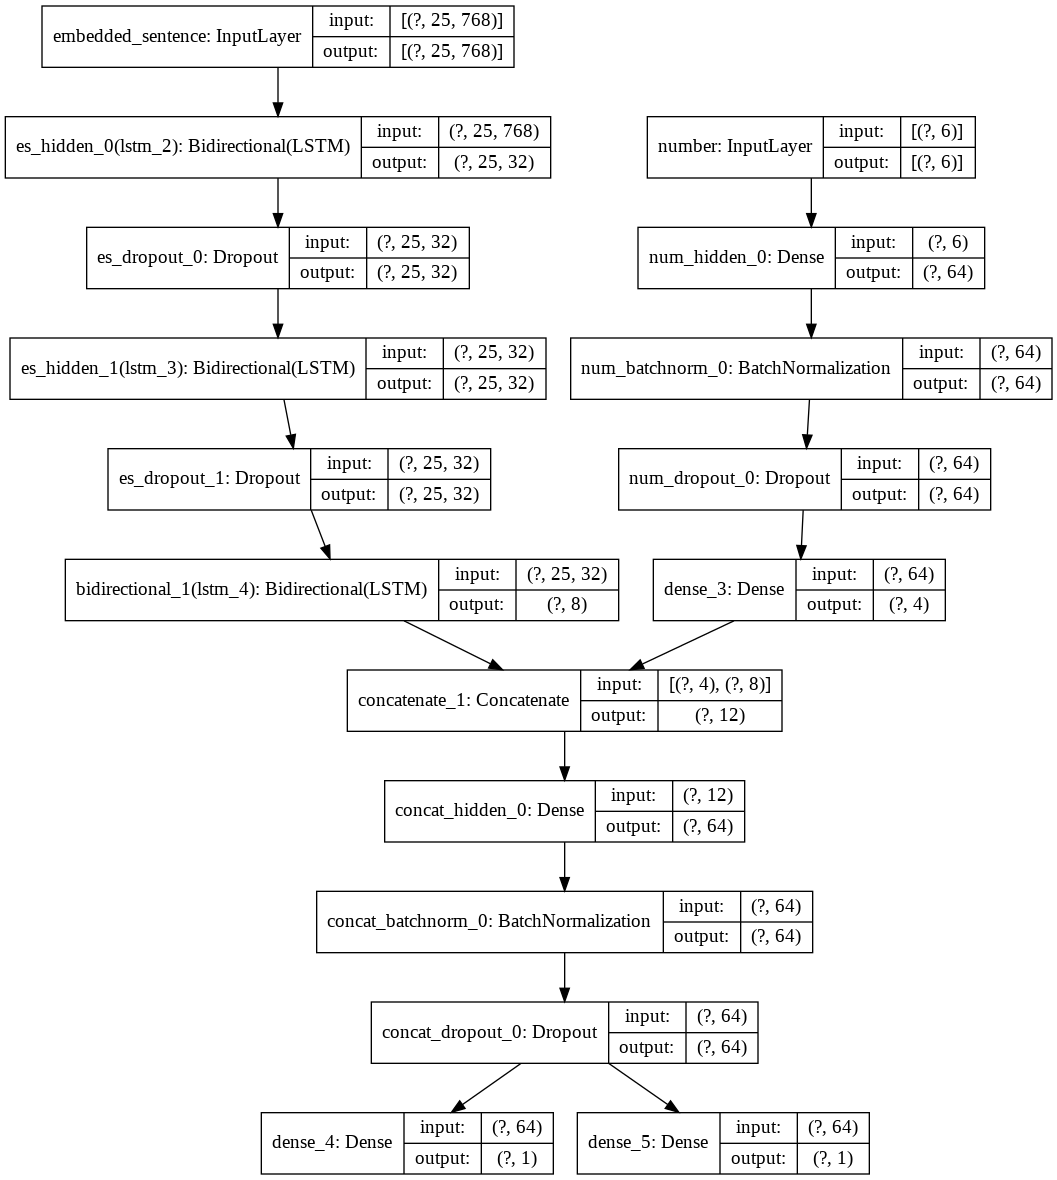

In [ ]:
tf.keras.utils.plot_model(fin_model, "fin_model.png", show_shapes=True)

In [ ]:
#split data to train/dev
from sklearn import preprocessing

sen_train, sen_dev = train_test_split(embedded_sentences,test_size=0.1)
num_train, num_dev = train_test_split(df_num,test_size=0.1)

x = num_train.values 
y = num_dev.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
num_train = pd.DataFrame(x_scaled)
num_dev = pd.DataFrame(min_max_scaler.transform(y))

up_down_pred_train, up_down_pred_dev = train_test_split(up_down,test_size=0.1)
net_pred_train, net_pred_dev = train_test_split(net+25,test_size=0.1) 

In [ ]:
print(num_train,sen_train,net_pred_train)

In [ ]:
df_sen.iloc[1,1]

'Bush puts foot down on Georgian conflict'

In [ ]:
sentence_embeddings_1 = model.encode('Bush puts foot down on Georgian conflict')
sentence_embeddings_2 = embedded_sentences[1,1,:]
print(len(sentence_embeddings_1),np.count_nonzero(sentence_embeddings_1==sentence_embeddings_2))

768 768


In [ ]:
tf.keras.backend.clear_session()

class PrintDot(K.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch%100 ==0 : print(' ')
    print('.',end=' ')

lr_schedule = K.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch/20)
)


fin_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.727e-2),loss=['mean_squared_error','binary_crossentropy'],metrics=['mse'])
history = fin_model.fit(x=[num_train,sen_train],y=[net_pred_train,up_down_pred_train],batch_size=64,epochs=100,verbose=0,validation_split=0.1,callbacks=[PrintDot()])
#callbacks=[tf.keras.callbacks.ReduceLROnPlateau(patience=5),tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True),tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)]

 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  This is separate from the ipykernel package so we can avoid doing imports until


(0.0001, 0.15757960783506433, 10.0, 300.0)

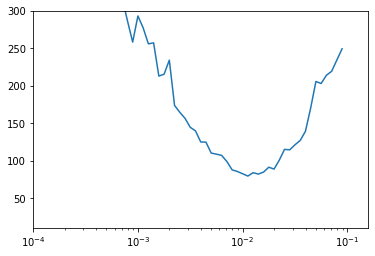

In [ ]:
#checkin best learning rate for optimizer => about 0.5e-2
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 0, 10, 300])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  This is separate from the ipykernel package so we can avoid doing imports until


(1e-06, 0.15757960783506433, 0.15, 0.3)

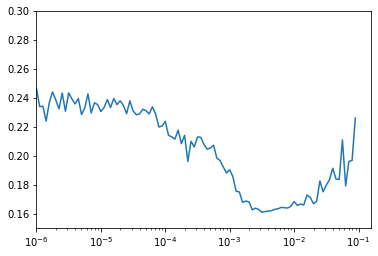

In [ ]:
#checkin best learning rate for optimizer
plt.semilogx(history.history["lr"], history.history["dense_2_mse"])
plt.axis([1e-6, 0, 0.15, 0.3])

Text(0.5, 1.0, 'Training and validation loss')

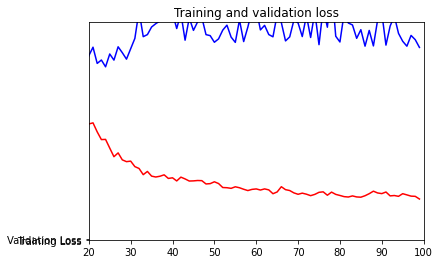

In [ ]:


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))


# Plot training and validation loss per epoch

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.axis([20, 100, 0, 250])

plt.title('Training and validation loss')

In [ ]:
prediction = fin_model.predict([num_dev,sen_dev])[0] #model seems to be predicting well at net_pred so use threshold 25 to predict if it rised or not
prediction = tf.greater(prediction, 25)
y_dev_boolean = tf.greater(np.array(up_down_pred_dev,dtype='float32'),0.5)
plus_minus = []
for i in range(up_down_pred_dev.shape[0]):
  if prediction[i]==y_dev_boolean[i]:
    plus_minus.append('Success')
  else:
    plus_minus.append('Fail')
print('Accuracy of predicting +/- is ',(plus_minus.count('Success')*100)/len(plus_minus),'%')

Accuracy of predicting +/- is  54.2713567839196 %


In [ ]:
print(len(prediction),len(y_dev_boolean))

199 199


In [ ]:
print(fin_model.predict([num_dev,sen_dev])) 

In [ ]:
prediction = fin_model.predict([num_dev,sen_dev])[0]
prediction = tf.greater(prediction, 25)
y_dev_boolean = tf.greater(np.array(up_down_pred_dev,dtype='float32'),0.5)
surplus_deficit = []
earned_money = []
for i in range(up_down_pred_dev.shape[0]):
  if prediction[i]==True and y_dev_boolean[i]==True:
    surplus_deficit.append('Surplus') #bought stock when prediction>0 and actual change was >0
    earned_money.append(np.array(net_pred_dev)[i])
  if prediction[i]==True and y_dev_boolean[i]==False:
    surplus_deficit.append('Deficit')
    earned_money.append(np.array(net_pred_dev)[i])

print('Earned money for chance of ',(surplus_deficit.count('Surplus')*100)/len(surplus_deficit),'%')
print('Earned money = ',np.sum(np.array(earned_money)-25)*10,'$')

Earned money for chance of  56.15384615384615 %
Earned money =  1870.0 $
